
# Online Artifact Detection with Riemannian Potato

Example of Riemannian Potato [1]_ applied on EEG time-series to detect
artifacts in online processing. It is computed only for two channels to display
intuitive visualizations.


In [1]:
# Authors: Quentin Barthélemy & David Ojeda
#
# License: BSD (3-clause)

from functools import partial
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from mne.datasets import sample
from mne.io import read_raw_fif
from mne import make_fixed_length_epochs

from pyriemann.estimation import Covariances
from pyriemann.clustering import Potato
from pyriemann.utils.viz import _add_alpha

In [2]:
@partial(np.vectorize, excluded=['potato'])
def get_zscores(cov_00, cov_01, cov_11, potato):
    cov = np.array([[cov_00, cov_01], [cov_01, cov_11]])
    with np.testing.suppress_warnings() as sup:
        sup.filter(RuntimeWarning)
        return potato.transform(cov[np.newaxis, ...])


def plot_potato_2D(ax, cax, X, Y, p_zscores, p_center, covs, p_colors, clabel):
    qcs = ax.contourf(X, Y, p_zscores, levels=20, vmin=p_zscores.min(),
                      vmax=p_zscores.max(), cmap='RdYlBu_r', alpha=0.5)
    ax.contour(X, Y, p_zscores, levels=[z_th], colors='k')
    sc = ax.scatter(covs[:, 0, 0], covs[:, 1, 1], c=p_colors)
    ax.scatter(p_center[0, 0], p_center[1, 1], c='k', s=100)
    if cax:
        cbar = fig.colorbar(qcs, cax=cax)
    else:
        cbar = fig.colorbar(qcs, ax=ax)
    cbar.ax.set_ylabel(clabel)
    return sc


def plot_sig(ax, time, sig):
    ax.axis((time[0], time[-1], -15, 15))
    pl, = ax.plot(time, sig, lw=0.75)
    ax.axhspan(
        -14, 14, edgecolor='k', facecolor='none',
        xmin=-test_time_start / (test_time_end - test_time_start),
        xmax=(duration - test_time_start) / (test_time_end - test_time_start))
    return pl

## Load EEG data



In [3]:
from filenames_and_paths import *
import mne

# raw_fname = os.path.join(sample.data_path(), 'MEG', 'sample',
#                          'sample_audvis_filt-0-40_raw.fif')
# raw = read_raw_fif(raw_fname, preload=True, verbose=False)

raw = mne.io.read_raw_brainvision(folders.raw_data + path014 + filenames014[0] + '.vhdr', preload=True)
raw = raw.drop_channels(["EOG", "BIP1", "M1", "M2"])

sfreq = int(raw.info['sfreq']) 

Extracting parameters from ./raw_data/rest_14/ACP_INP0014_REST1_1pnt_1vis.vhdr...
Setting channel info structure...
Reading 0 ... 1013446  =      0.000 ...   494.847 secs...


## Offline processing of EEG data



In [4]:
# Apply common average reference on EEG channels
raw.pick_types(meg=False, eeg=True).apply_proj()

# Select two EEG channels for the example, preferably without artifact at the
# beginning, to have a reliable calibration

ch_names = ['Fp1', 'PO3']
# ch_names = ['EEG 001', 'EEG 002']

# Apply band-pass filter between 1 and 35 Hz
raw.filter(1., 35., method='iir', picks=ch_names)

# Epoch time-series with a sliding window
duration = 2.5    # duration of epochs
interval = 0.2    # interval between successive epochs
epochs = make_fixed_length_epochs(
    raw, duration=duration, overlap=duration - interval, verbose=False)
epochs_data = 5e5 * epochs.get_data(picks=ch_names, copy=False)

# Estimate spatial covariance matrices
covs = Covariances(estimator='lwf').transform(epochs_data)

# %matplotlib qt
# raw.pick(ch_names).plot()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 35.00 Hz: -6.02, -6.02 dB

Using data from preloaded Raw for 2462 events and 5120 original time points ...
0 bad epochs dropped


In [5]:
# %matplotlib inline

## Offline Calibration of Potato

2D projection of the z-score map of the Riemannian potato, for 2x2 covariance
matrices (in blue if clean, in red if artifacted) and their reference matrix
(in black). The colormap defines the z-score and a chosen isocontour defines
the potato. It reproduces Fig 1 of reference [2]_.



In [6]:
z_th = 2.0       # z-score threshold
train_covs = 40  # nb of matrices to train the potato

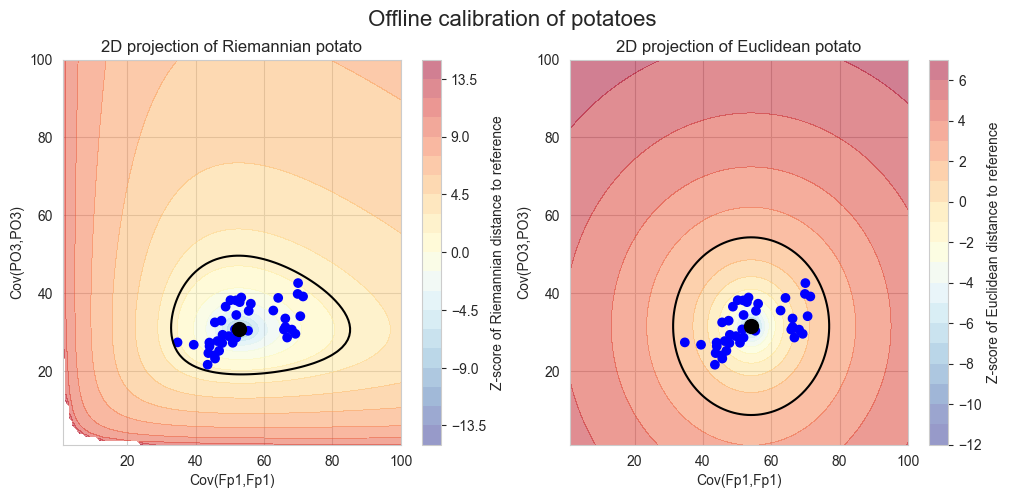

In [7]:
# Calibrate potato by unsupervised training on first matrices: compute a
# reference matrix, mean and standard deviation of distances to this reference.
train_set = range(train_covs)
rpotato = Potato(metric='riemann', threshold=z_th).fit(covs[train_set])
rp_center = rpotato._mdm.covmeans_[0]
epotato = Potato(metric='euclid', threshold=z_th).fit(covs[train_set])
ep_center = epotato._mdm.covmeans_[0]

rp_labels = rpotato.predict(covs[train_set])
rp_colors = ['b' if ll == 1 else 'r' for ll in rp_labels.tolist()]
ep_labels = epotato.predict(covs[train_set])
ep_colors = ['b' if ll == 1 else 'r' for ll in ep_labels.tolist()]

# Zscores in the horizontal 2D plane going through the reference
X, Y = np.meshgrid(np.linspace(1, 100, 100), np.linspace(1, 100, 100))
rp_zscores = get_zscores(X, np.full_like(X, rp_center[0, 1]), Y,
                         potato=rpotato)
rp_mzscores = np.ma.masked_where(~np.isfinite(rp_zscores), rp_zscores)
ep_zscores = get_zscores(X, np.full_like(X, ep_center[0, 1]), Y,
                         potato=epotato)

# Plot calibration
xlabel = 'Cov({},{})'.format(ch_names[0], ch_names[0])
ylabel = 'Cov({},{})'.format(ch_names[1], ch_names[1])

fig, axs = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
fig.suptitle('Offline calibration of potatoes', fontsize=16)
axs[0].set(xlabel=xlabel, ylabel=ylabel,
           title='2D projection of Riemannian potato')
plot_potato_2D(axs[0], None, X, Y, rp_mzscores, rp_center, covs[train_set],
               rp_colors, 'Z-score of Riemannian distance to reference')
axs[1].set(xlabel=xlabel, ylabel=ylabel,
           title='2D projection of Euclidean potato')
plot_potato_2D(axs[1], None, X, Y, ep_zscores, ep_center, covs[train_set],
               ep_colors, 'Z-score of Euclidean distance to reference')
plt.show()

## Online Artifact Detection with Potato

Detect artifacts/outliers on test set, with an animation to imitate an online
acquisition, processing and artifact detection of EEG time-series.
Initialized with an offline calibration, the online potato can be [2]_:

* static: it is never updated, damaging its efficiency over time;
* semi-dynamic: it is updated when EEG is not artifacted.



In [8]:
is_static = False       # static or semi-dynamic mode

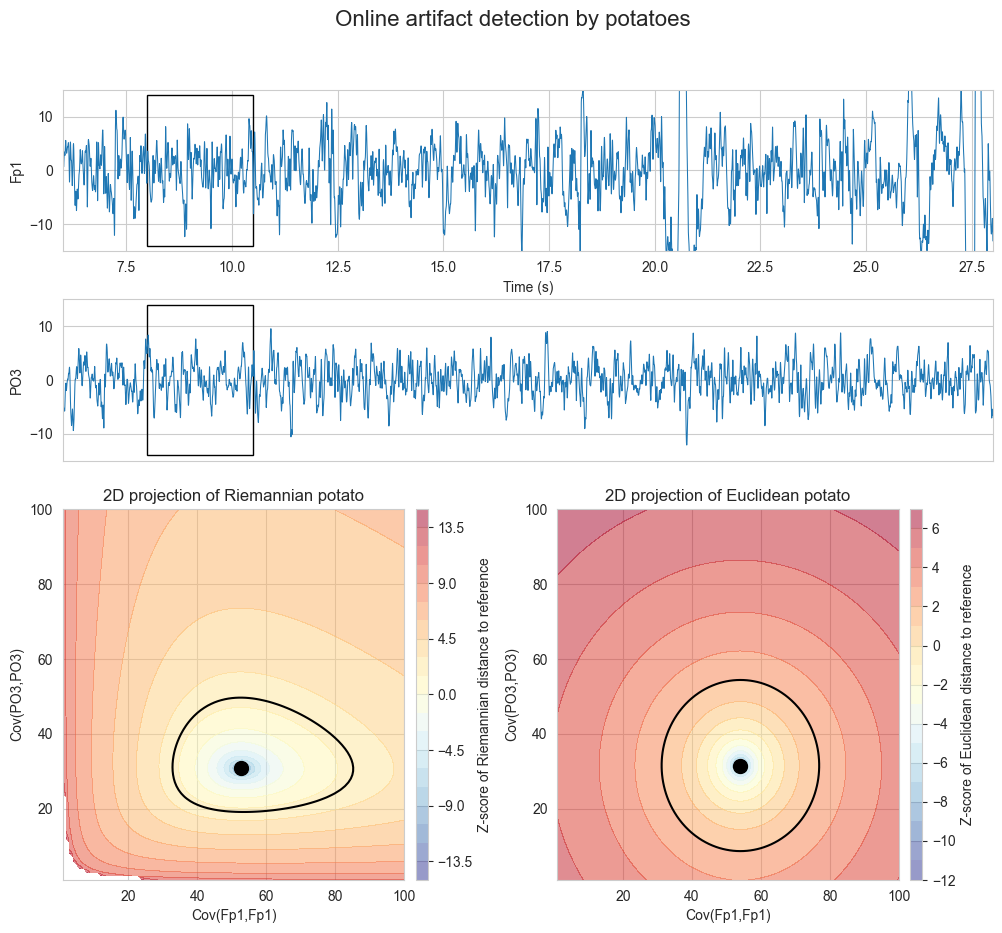

In [9]:
# Prepare data for online detection
test_covs_max = 300     # nb of matrices to visualize in this example
test_covs_visu = 30     # nb of matrices to display simultaneously
test_time_start = -2    # start time to display signal
test_time_end = 20       # end time to display signal

time_start = train_covs * interval + test_time_start
time_end = train_covs * interval + test_time_end
time = np.linspace(time_start, time_end, int((time_end - time_start) * sfreq),
                   endpoint=False)
eeg_data = 3e5 * raw.get_data(picks=ch_names)
sig = eeg_data[:, int(time_start * sfreq):int(time_end * sfreq)]
covs_visu, rp_colors, ep_colors = np.empty([0, 2, 2]), [], []
alphas = np.linspace(0, 1, test_covs_visu)

fig = plt.figure(figsize=(12, 10), constrained_layout=False)
fig.suptitle('Online artifact detection by potatoes', fontsize=16)
gs = fig.add_gridspec(nrows=4, ncols=40, top=0.90, hspace=0.3, wspace=1.0)
ax_sig0 = fig.add_subplot(gs[0, :], xlabel='Time (s)', ylabel=ch_names[0])
pl_sig0 = plot_sig(ax_sig0, time, sig[0])
ax_sig1 = fig.add_subplot(gs[1, :], ylabel=ch_names[1])
pl_sig1 = plot_sig(ax_sig1, time, sig[1])
ax_sig1.set_xticks([])
ax_rp = fig.add_subplot(gs[2:4, 0:15], xlabel=xlabel, ylabel=ylabel,
                        title='2D projection of Riemannian potato')
cax_rp = fig.add_subplot(gs[2:4, 15])
p_rp = plot_potato_2D(ax_rp, cax_rp, X, Y, rp_mzscores, rp_center, covs_visu,
                      rp_colors, 'Z-score of Riemannian distance to reference')
ax_ep = fig.add_subplot(gs[2:4, 21:36], xlabel=xlabel, ylabel=ylabel,
                        title='2D projection of Euclidean potato')
cax_ep = fig.add_subplot(gs[2:4, 36])
p_ep = plot_potato_2D(ax_ep, cax_ep, X, Y, ep_zscores, ep_center, covs_visu,
                      ep_colors, 'Z-score of Euclidean distance to reference')

In [21]:
# Prepare animation for online detection
def online_detect(t):
    global time, sig, covs_visu

    # Online artifact detection
    rp_label = rpotato.predict(covs[np.newaxis, t])[0]
    ep_label = epotato.predict(covs[np.newaxis, t])[0]
    if not is_static:
        if rp_label == 1:
            rpotato.partial_fit(covs[np.newaxis, t], alpha=1 / t)
        if ep_label == 1:
            epotato.partial_fit(covs[np.newaxis, t], alpha=1 / t)

    # Update data
    time_start = t * interval + test_time_end
    time_end = (t + 1) * interval + test_time_end
    time_ = np.linspace(time_start, time_end, int(interval * sfreq),
                        endpoint=False)
    time = np.r_[time[int(interval * sfreq):], time_]
    print(time[10:])
    print(len(time))
    print(sig.shape)
    if len(time) != sig.shape[1]:
        sig = sig[:, :-1]
    sig = np.hstack((sig[:, int(interval*sfreq):],
                     eeg_data[:, int(time_start*sfreq):int(time_end*sfreq)]))
    covs_visu = np.vstack((covs_visu, covs[np.newaxis, t]))
    rp_colors.append('b' if rp_label == 1 else 'r')
    ep_colors.append('b' if ep_label == 1 else 'r')
    if len(covs_visu) > test_covs_visu:
        covs_visu = covs_visu[1:]
        rp_colors.pop(0)
        ep_colors.pop(0)
    rp_colors_ = _add_alpha(rp_colors, alphas)
    ep_colors_ = _add_alpha(ep_colors, alphas)

    # Update plot
    pl_sig0.set_data(time, sig[0])
    pl_sig0.axes.set_xlim(time[0], time[-1])
    pl_sig1.set_data(time, sig[1])
    pl_sig1.axes.set_xlim(time[0], time[-1])
    p_rp.set_offsets(np.c_[covs_visu[:, 0, 0], covs_visu[:, 1, 1]])
    p_rp.set_color(rp_colors_)
    p_ep.set_offsets(np.c_[covs_visu[:, 0, 0], covs_visu[:, 1, 1]])
    p_ep.set_color(ep_colors_)
    return pl_sig0, pl_sig1, p_rp, p_ep


interval_display = 1.0  # can be changed for a slower display

potato = FuncAnimation(fig, online_detect,
                       frames=range(train_covs, test_covs_max),
                       interval=interval_display, blit=False, repeat=False)

## Plot online detection



In [22]:
# Plot complete visu: a dynamic display is required
plt.show()

# Plot only 10s, for animated documentation
try:
    from IPython.display import HTML
except ImportError:
    raise ImportError("Install IPython to plot animation in documentation")

plt.rcParams["animation.embed_limit"] = 10
with open("data.html", "w") as file:
    file.write(HTML(potato.to_jshtml(fps=5, default_mode='loop')).data)


[ 9.39990234  9.40039062  9.40087891 ... 28.19853301 28.199022
 28.199511  ]
45056
(2, 45057)
FIXED
[ 9.39990234  9.40039062  9.40087891 ... 28.19853301 28.199022
 28.199511  ]
45056
(2, 45056)
[ 9.59960938  9.60009766  9.60058594 ... 28.19853301 28.199022
 28.199511  ]
45056
(2, 45056)
[ 9.79931641  9.79980469  9.80029297 ... 28.39853301 28.399022
 28.399511  ]
45056
(2, 45056)
FIXED
[ 9.79931641  9.79980469  9.80029297 ... 28.39853301 28.399022
 28.399511  ]
45056
(2, 45056)
[ 9.99902344  9.99951172 10.         ... 28.59853301 28.599022
 28.599511  ]
45056
(2, 45056)
[10.19873047 10.19921875 10.19970703 ... 28.79853301 28.799022
 28.799511  ]
45056
(2, 45056)
FIXED
[10.19873047 10.19921875 10.19970703 ... 28.79853301 28.799022
 28.799511  ]
45056
(2, 45056)
[10.3984375  10.39892578 10.39941406 ... 28.99853301 28.999022
 28.999511  ]
45056
(2, 45056)
FIXED
[10.3984375  10.39892578 10.39941406 ... 28.99853301 28.999022
 28.999511  ]
45056
(2, 45056)
[10.59814453 10.59863281 10.59912109

Animation size has reached 10698391 bytes, exceeding the limit of 10485760.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


[16.38964844 16.39013672 16.390625   ... 34.99853301 34.999022
 34.999511  ]
45056
(2, 45056)
FIXED
[16.38964844 16.39013672 16.390625   ... 34.99853301 34.999022
 34.999511  ]
45056
(2, 45056)
[16.58935547 16.58984375 16.59033203 ... 35.19853301 35.199022
 35.199511  ]
45056
(2, 45056)
[16.7890625  16.78955078 16.79003906 ... 35.39853301 35.399022
 35.399511  ]
45056
(2, 45056)
FIXED
[16.7890625  16.78955078 16.79003906 ... 35.39853301 35.399022
 35.399511  ]
45056
(2, 45056)
[16.98876953 16.98925781 16.98974609 ... 35.59853301 35.599022
 35.599511  ]
45056
(2, 45056)
[17.18847656 17.18896484 17.18945312 ... 35.79853301 35.799022
 35.799511  ]
45056
(2, 45056)
FIXED
[17.18847656 17.18896484 17.18945312 ... 35.79853301 35.799022
 35.799511  ]
45056
(2, 45056)
[17.38818359 17.38867188 17.38916016 ... 35.99853301 35.999022
 35.999511  ]
45056
(2, 45056)
FIXED
[17.38818359 17.38867188 17.38916016 ... 35.99853301 35.999022
 35.999511  ]
45056
(2, 45056)
[17.58789062 17.58837891 17.58886719